In [13]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

import SIRD_Model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,header.index("Dates")]
    infected = infectionData[:,header.index("Infected")]
    recovered = infectionData[:,header.index("Recovered")]
    deaths = infectionData[:,header.index("Deaths")]
    vacc = infectionData[:,header.index("Vaccinated")]
    vacc = vacc.astype(float)
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    return dates, infected, recovered, deaths, vacc

def showCurves(infected, recovered, dead, vacc, pop, q, graph=True):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - vacc*q - recovered - dead
    
    nextIterMatrix, sirdMatrix = getSIRDVMatrices(suscept, infected, recovered, dead, vacc, pop)
    
    paramMatrix = np.zeros((len(sirdMatrix), 4)) #setup param (time dependent) matrix
    for t in range(len(sirdMatrix)): #solve each parameter list for every t
        paramMatrix[t] = np.linalg.lstsq(sirdMatrix[t], nextIterMatrix[t], rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    
    transRate = paramMatrix[:,0] #beta
    arecovRate = paramMatrix[:,1] #Gamma 
    deathRate = paramMatrix[:,2] #New
    vaccRate = paramMatrix[:,3] #Psi
    
    if(graph):

        #plot rates over time
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
        ax.plot(vacc, color = 'green', label = 'vaccinated')
        ax.plot(asym, color = 'yellow', label = 'asymptomatic')
        ax.plot(infected, color='red', label='infected')
        ax.plot(recovered, color='cyan', label='recovered')
        ax.plot(dead, color='black', label='dead')

        fig2, ax2 = plt.subplots(5, 1, figsize=(18,8))
        ax2[0].plot(transRate, color='orange', label='Transmission Rate')
        ax2[1].plot(asymRate, color = 'red', label = 'Asymptomatic rate')
        ax2[2].plot(recovRate, color='green', label='Recovery Rate')
        ax2[3].plot(aRecovRate, color='brown', label='Recovery Rate')
        ax2[4].plot(deathRate, color='black', label='Death Rate')
    
    return paramMatrix

def getSIRDVMatrices(suscept, infect, recov, dead, vacc, pop):
    sirdMatrix = np.zeros((len(recov) - 1, 5, 4))
    nextIterMatrix = np.zeros((len(recov) - 1, 5, 1)) #the S(t+1), I(t+1), ... matrix
    
  
    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[:,0,0] = -((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1])) 
    sirdMatrix[:,0,3] = -suscept[0:-1]
    sirdMatrix[:,1,0] = ((suscept[0:-1] * infect[0:-1]) / (suscept[0:-1]+infect[0:-1])) 
    sirdMatrix[:,1,1] = -infect[0:-1]
    sirdMatrix[:,1,2] = -infect[0:-1]

    
    sirdMatrix[:,2,1] = infect[0:-1]
    sirdMatrix[:,2,3] = -recov[0:-1]
    
    sirdMatrix[:,3,2] = infect[0:-1]
    
    sirdMatrix[:,4,3] = suscept + recov
    
    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[:,0,0] = suscept[1:] - suscept[0:-1]
    nextIterMatrix[:,1,0] = infect[1:] - infect[0:-1]
    nextIterMatrix[:,2,0] = recov[1:] - recov[0:-1]
    nextIterMatrix[:,3,0] = dead[1:] - dead[0:-1]
    nextIterMatrix[:,4,0] = vacc[1:]- vacc[0:-1]

    return nextIterMatrix, sirdMatrix

def getSIRDVMatricesFlat(suscept, infect, recov, dead, vacc, pop): #get the matrices in a 2d format, second dimension is put into the first
    y, X= getSIRDVMatrices(suscept, infect, recov, dead, vacc, pop)
    
    T = len(y)
    rowCount = np.shape(y)[1]
    newY = np.zeros((T*rowCount, 1))
    newX = np.zeros((T*rowCount, np.shape(X)[2]))
    
    #map to flat matrix
    for t in range(T):
        for i in range(rowCount):
            newY[t*rowCount + i] = y[t, i]
            newX[t*rowCount + i] = X[t, i]
    return newY, newA

def getQandParams(infect, recov, dead, vacc, pop, resol=150, qMin = -1, qMax = 1, w=.9, lamda=10, graph=True):
    qList = np.zeros(resol)
    optimList = np.zeros(resol)
    if(qMin == -1): #set if not set by the user
        qMin = max((infect + recov + vacc + dead)/pop) #Changed for SIRDV
    for i in range(resol):
        qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

    #for each q check optimal function
    paramList = np.zeros((resol, 4))
    lossList = np.zeros(resol)
    for i in range(len(qList)):
        suscept = pop*qList[i] - infect - recov - dead - vacc*q #Changed for SIRDV
        nextIterMatrix, sirdMatrix = getSIRDVMatricesFlat(suscept, infect, recov, dead, vacc, pop)

        #construct y and A, see paper for solving the lasso optimization
        T = int(len(nextIterMatrix)/5)
        y = np.zeros((T*5, 1))
        A = np.zeros((T*5, 4))
        for t in range(T):
            y[5*t+0] = nextIterMatrix[5*t+0] * np.sqrt(w**(T - t))
            y[5*t+1] = nextIterMatrix[5*t+1] * np.sqrt(w**(T - t))
            y[5*t+2] = nextIterMatrix[5*t+2] * np.sqrt(w**(T - t))
            y[5*t+3] = nextIterMatrix[5*t+3] * np.sqrt(w**(T - t))
            y[5*t+4] = nextIterMatrix[5*t+4] * np.sqrt(w**(T - t))
            
            A[5*t+0] = sirdMatrix[5*t+0] * np.sqrt(w**(T - t))
            A[5*t+1] = sirdMatrix[5*t+1] * np.sqrt(w**(T - t))
            A[5*t+2] = sirdMatrix[5*t+2] * np.sqrt(w**(T - t))
            A[5*t+3] = sirdMatrix[5*t+3] * np.sqrt(w**(T - t))
            A[5*t+4] = sirdMatrix[5*t+4] * np.sqrt(w**(T - t))
          
        #solve for y and A
        model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True)
        model.fit(A,y)
        paramList[i] = model.coef_

        lossList[i] = (1.0/T) * np.linalg.norm((A @ paramList[i]) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(paramList[i], ord=1)
    
    bestQIndex = 0
    for i in range(resol):
        if(optimList[bestQIndex] > optimList[i]):
            bestQIndex = i
    if(graph):
        #plot objective function with q on the x-axis
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(qList, lossList, color='blue')        

    return qList[bestQIndex], paramList[bestQIndex]

#predict the next some days using constant parameters, q and params will be calculated if not set
def calculateFuture(infect, recov, dead,vacc, pop, daysToPredict, params=None, q=None):
    if(q == None): #calculate q if not set
        q, dummyParams = getQandParams(infect, recov, dead,vacc, pop, graph=False)
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead - vacc*q
    dt, A = getSIRDVMatrices(suscept, infect, recov, dead,vacc,pop)

    if(params == None): #calculate params if not set, average from final 10 percent of days
        paramMatrix = showCurves(infect, recov, dead,vacc, pop, q, graph=False)
        averageSize = int(len(infect)/5) #use the last 20% of data points to average params
        params = sum(paramMatrix[-averageSize:])/averageSize
    
    sirdPredict = np.zeros((len(A) + daysToPredict, 5,4))
    dtPredict = np.zeros((len(dt) + daysToPredict, 5, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)
    vaccPredict = np.zeros(len(vacc)+daysToPredict)
    
    
    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead
    vaccPredict[0:len(vacc)] = vacc
    T = len(suscept)
    for t in range(T - 1, T + daysToPredict - 1): #go from last element in known list to end of prediction
        #populate the 4x3 matrix with parameters
        sirdPredict[:,0,0] = -((susceptPredict[0:-1] * infectPredict[0:-1]) / (susceptPredict[0:-1]+infectPredict[0:-1])) 
        sirdPredict[:,0,3] = -susceptPredict[0:-1]
        sirdPredict[:,1,0] = ((susceptPredict[0:-1] * infectPredict[0:-1]) / (susceptPredict[0:-1]+infectPredict[0:-1])) 
        sirdPredict[:,1,1] = -infectPredict[0:-1]
        sirdPredict[:,1,2] = -infectPredict[0:-1]


        sirdPredict[:,2,1] = infectPredict[0:-1]
        sirdPredict[:,2,3] = -recovPredict[0:-1]

        sirdPredict[:,3,2] = infectPredict[0:-1]

        sirdPredict[:,4,3] = suscept + recov

        
        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
        vaccPredict[t+1] = vaccPredict[t] + dtPredict[t,4,0]
        for t1 in range(1, T-1):
            sirdPredict[:,0,0] = -((susceptPredict[0:-1] * infectPredict[0:-1]) / (susceptPredict[0:-1]+infectPredict[0:-1])) 
            sirdPredict[:,0,3] = -susceptPredict[0:-1]
            sirdPredict[:,1,0] = ((susceptPredict[0:-1] * infectPredict[0:-1]) / (susceptPredict[0:-1]+infectPredict[0:-1])) 
            sirdPredict[:,1,1] = -infectPredict[0:-1]
            sirdPredict[:,1,2] = -infectPredict[0:-1]


            sirdPredict[:,2,1] = infectPredict[0:-1]
            sirdPredict[:,2,3] = -recovPredict[0:-1]

            sirdPredict[:,3,2] = infectPredict[0:-1]

            sirdPredict[:,4,3] = suscept + recov


            #find next dtPredict
            dtPredict[t,:,0] = (sirdPredict[t] @ params)

            #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
            susceptPredict[t+1] = 0.5*susceptPredict[t+1] + 0.5*susceptPredict[t] + dtPredict[t,0,0]
            infectPredict[t+1] = 0.5*infectPredict[t+1]+ 0.5*infectPredict[t] + dtPredict[t,1,0]
            recovPredict[t+1] = 0.5*recovPredict[t+1]+ 0.5*recovPredict[t] + dtPredict[t,2,0]
            deadPredict[t+1] = 0.5*deadPredict[t+1] + 0.5*deadPredict[t]+ dtPredict[t,3,0]
            vaccPredict[t+1] = 0.5*vaccPredict[t+1] + 0.5*vaccPredict[t] + dtPredict[t,4,0]
        
        
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params

#predict future days that are not known
def predictFuture(infect, tests, recov, dead, pop, daysToPredict, param=None, qVal=None):
    pS, pI, pR, pD, q, params = calculateFuture(infect, tests, recov, dead, pop, daysToPredict, params=param, q=qVal)
    
    suscept = q*pop - infect -vacc*q - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, vacc, pop, daysToPredict, param=None, qVal=None):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], vacc[0:-daysToPredict],pop, daysToPredict, params=param, q=qVal)
    
    suscept = q*pop - infect - recov - vacc*q - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    
def calculateConstantParams(infected, recovered, dead,vacc, pop, q):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - recovered - vacc*q - dead
    
    dy, X = getSIRDVMatrices(suscept, infected, recovered, dead, vacc)
    dy, X = flattenSIRDVMatrix(dy,X)
    params = np.linalg.lstsq(X, dy, rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    return params

def flattenSIRDVMatrix(y, X): #get the matrices in a 2d format, time dimension is put into the first
    T = len(y)
    rowCount = np.shape(y)[1]
    newY = np.zeros((T*rowCount, 1))
    newX = np.zeros((T*rowCount, np.shape(X)[2]))
    
    #map to flat matrix
    for t in range(T):
        for i in range(rowCount):
            newY[t*rowCount + i] = y[t, i]
            newX[t*rowCount + i] = X[t, i]
            
    return newY, newX


best q found:  0.1


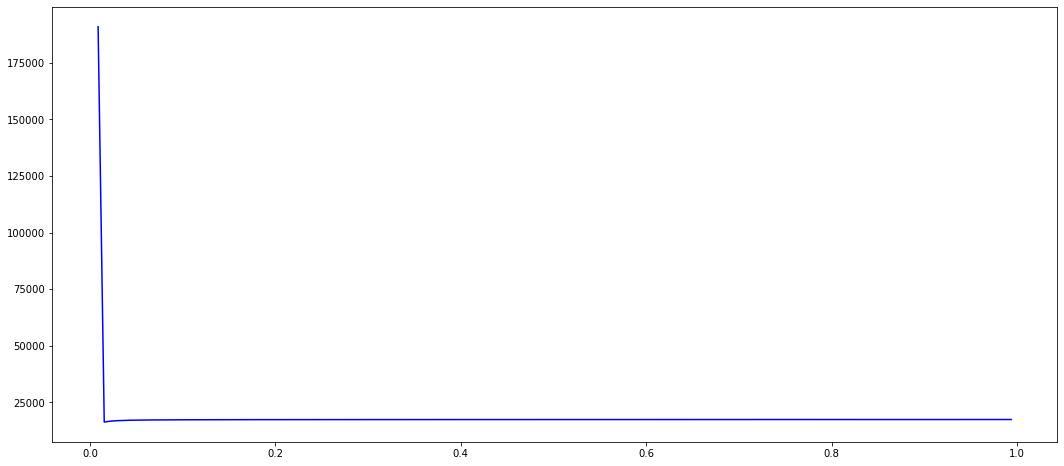

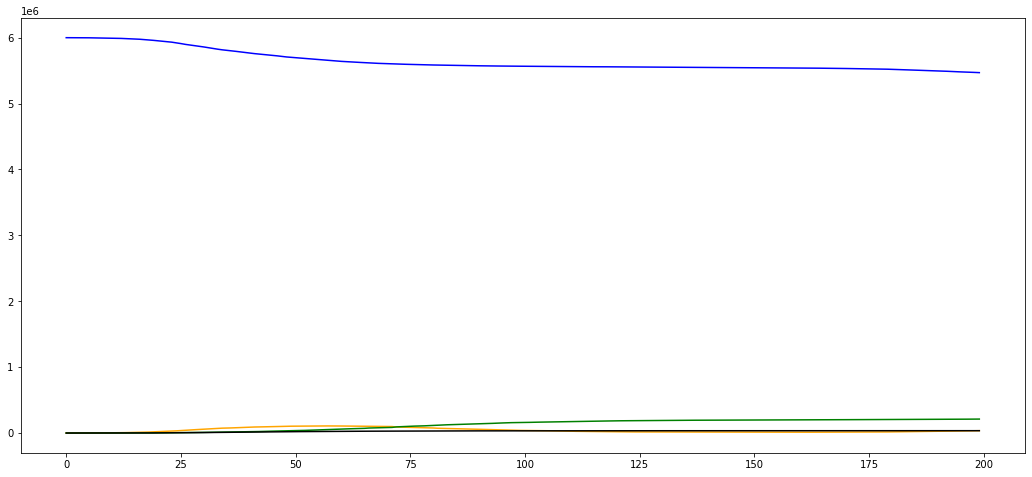

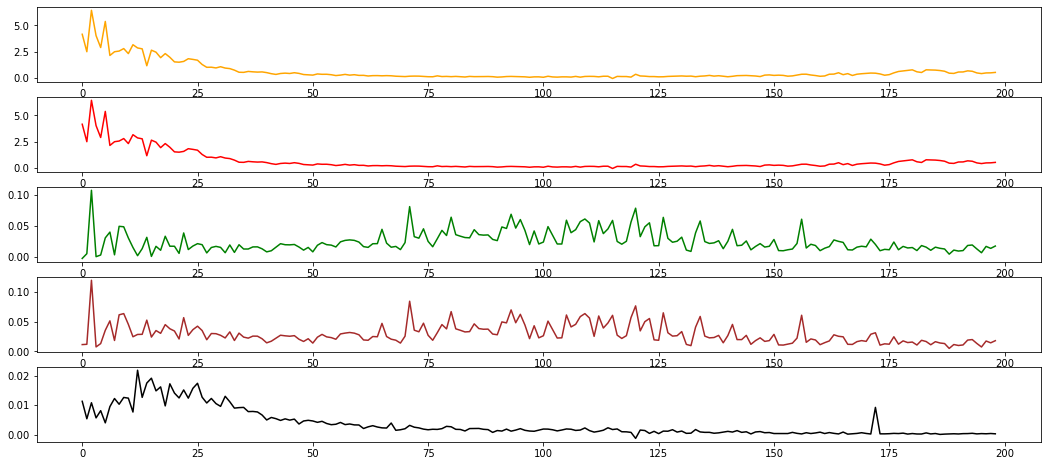

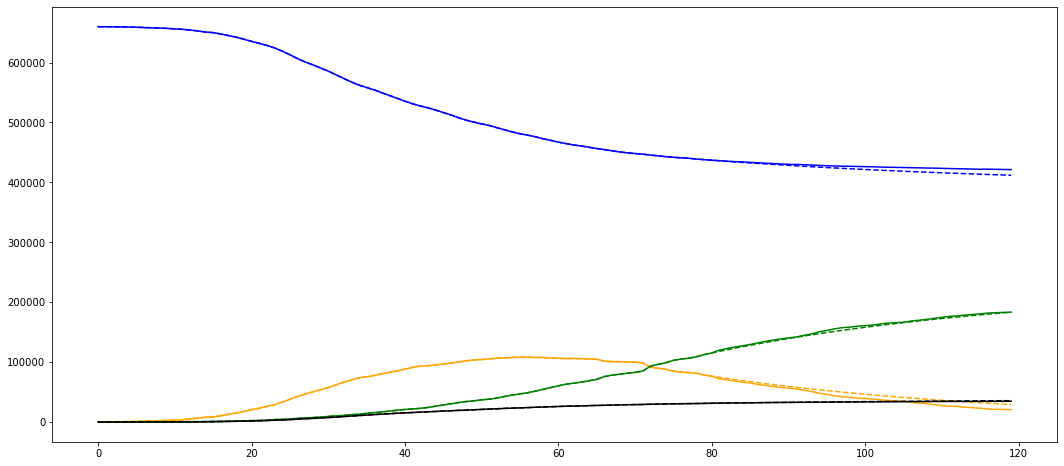

In [16]:
pathc="../Data/Italian Data/"
# modify the path syntax based on the current platform

filename = "National Data.csv"

dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

pop = 60000000
numDays = 200
vacc = vaccRaw[0:numDays]
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]

q = 0.1
_,params = getQandParams(infect, recov, dead, vacc, pop)
print("best q found: ", q)

paramMatrix = showCurves(infect, recov, dead, vacc, pop, q)
pop = 60000000
numDays = 120
daysToPredict = 40
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]



SIRD_Model.predictMatch(infectRaw[0:numDays],  recovRaw[0:numDays], deadRaw[0:numDays], vaccRaw[0:numDays], pop, daysToPredict, qVal=.011)